In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import itertools
from tqdm.contrib.concurrent import process_map
import scipy

np.random.seed(42)

/home/jk/projects/itmo/statistics/.venv/lib/pypy3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
SAMPLE_SIZE = [10, 100, 1000, 10_000]
QUANTILES = [0.01, 0.05, 0.5]
DISTRIBUTIONS = {
    "NORMAL": lambda n: np.random.normal(0, 1, n),
    "UNIFORM": lambda n: np.random.uniform(0, 1, n),
}
PRECISION = 100
SIGMA = 0.1
EPS_ZERO = 0.005
X_SPACE = np.linspace(0, 1, PRECISION)
NUM_EXPERIMENTS = 10_000
EXPERIMENT_PARAMS = tuple(itertools.product(DISTRIBUTIONS.keys(), SAMPLE_SIZE))

In [ ]:
def histogram_nbins(n):
    return math.floor(1 + 1.59 * math.log(n))

def gaussian_kernel(x, sigma): # N_0,1
    return (1 / np.sqrt(2 * np.pi) / sigma) * np.exp(-0.5 * x**2 / sigma**2)

def dup(arr):
    return np.array(list(map(lambda x: [x, x], arr))).flatten()

def make_kde(sample, xs, sigma):
    kde = np.array(sum(map(lambda r: gaussian_kernel((xs - r), sigma), sample))) / len(sample) #TODO: check formela, too long tails
    return kde

def make_hist(rs, bins):
    return np.histogram(rs, bins)

def make_ecdf(sample):
    sorted_sample = np.sort(sample)
    cdf_sample = np.cumsum(sorted_sample)
    cdf_sample /= cdf_sample[-1]
    return cdf_sample

def make_cdf(sample, xs):
    sorted_sample = np.sort(sample)
    cdf = np.searchsorted(sorted_sample, xs, side="right") / len(sample) # values on [0; 1]
    return cdf

In [19]:
def sample_quantile(sample, qs):
    assert all(0 <= q <= 1 for q in qs)
    assert len(sample) > 0

    sorted_sample = np.sort(sample)

    xqs = []
    for q in qs:
        i = int((len(sample) - 1) * q)

        xqs.append(
            sorted_sample[i]
            if i % 1 == 0
            else q * (sorted_sample[math.floor(i)] + sorted_sample[math.ceil(i)])
        )
    return np.array(xqs)

def cdf_quantile(sample, cdf, qs):
    assert len(sample) == len(cdf)
    assert all(0 <= q <= 1 for q in qs)
    i = np.searchsorted(cdf, qs)
    return sample[i]

def hist_quantile(hist, bins, qs):
    assert all(0 <= q <= 1 for q in qs)

    pdf_hist = hist / sum(hist)
    cdf_hist = np.cumsum(pdf_hist)
    i = np.searchsorted(cdf_hist, qs)
    qs_diff = qs - np.insert(cdf_hist, 0, 0)[i]
    bin_width = bins[1] - bins[0]
    qs_height = pdf_hist[i]
    qs_diff_width = qs_diff / qs_height
    xqs = bins[i] + qs_diff_width * bin_width

    return xqs

def kde_quantile(phi, xs, qs):
    assert len(phi) == len(xs)
    cdf_kde = np.cumsum(phi)
    cdf_kde = cdf_kde / cdf_kde[-1]
    return cdf_quantile(xs, cdf_kde, qs)

x_0.01 = 0.19999999999999998 ()
x_0.05 = 0.24 ()
x_0.5 = 0.45 ()


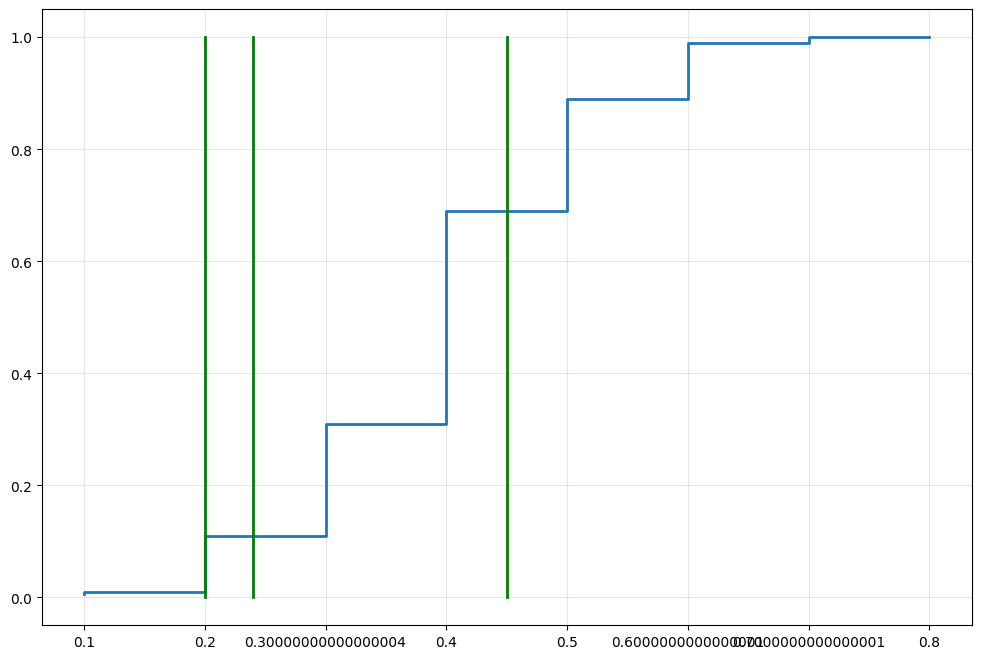

In [11]:
def test():
    scale = 0.1
    hist = np.array([0.01, 0.1, 0.2, 0.38, 0.2, 0.1, 0.01])
    bins = np.array([1.0, 2., 3., 4., 5., 6., 7., 8.]) * scale
    qs = QUANTILES

    cdf_hist = np.insert(np.cumsum(hist) / np.sum(hist), 0, EPS_ZERO)
    plt.figure(figsize=(12, 8))
    plt.plot(np.insert(dup(bins)[:-1], 0, float("-inf")), dup(cdf_hist), label="CDF(hist(x))", linewidth=2)
    # plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)
    kde_qs = hist_quantile(hist, bins, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        print(f"x_{qi} = {kde_qi} ()")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)
    plt.xticks(bins, bins)
    plt.plot()
    plt.grid(True, alpha=0.3)
    plt.show()

test()

In [37]:
def draw_kde(sample, xs, qs):
    kde_sample = make_kde(sample, xs, SIGMA)
    #PDF
    plt.figure(figsize=(12, 8))
    plt.plot(xs, kde_sample, label='KDE', linewidth=2)
    # plt.plot([0, 1], [1, 1], 'r--', label='генеральная плотность', linewidth=2)
    plt.title(f'n = {len(kde_sample)}')
    plt.xlabel('x')
    plt.ylabel('P(x)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # CDF
    plt.figure(figsize=(12, 8))
    plt.plot(xs, np.cumsum(kde_sample) / len(kde_sample), label="cdf(kde(x))", linewidth=2)
    # plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)

    kde_qs = kde_quantile(kde_sample, xs, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        print(f"q_{qi} = {kde_qi}")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)
    plt.title(f'cdf(kde(x)), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(kde(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)

In [39]:
def draw_hist(sample, qs):
    nbins = histogram_nbins(len(sample))
    hist, bins = make_hist(sample, nbins)

    # hist
    plt.figure(figsize=(12, 8))
    plt.hist(sample, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.bar(bins[:-1] + (1 / nbins / 2), hist / (np.sum(hist) / nbins), width=1 / nbins, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.plot([0, 1], [1, 1], 'r--', label='генеральная плотность', linewidth=2)
    plt.title(f'Гистограмма выборки размером {len(sample)}')
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')
    plt.grid(True, alpha=0.3)
    plt.show()

    # CDF (hist)
    cdf_hist = np.insert(np.cumsum(hist) / np.sum(hist), 0, EPS_ZERO)
    plt.figure(figsize=(12, 8))
    plt.plot(np.insert(dup(bins)[:-1], 0, float("-inf")), dup(cdf_hist), label="CDF(hist(x))", linewidth=2)
    # plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)

    kde_qs = hist_quantile(hist, bins, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        print(f"x_{qi} = {kde_qi} ({np.mean(sample < kde_qi)})")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)

    plt.xticks(bins, map(lambda x: f"{x:03f}", bins))
    plt.plot()
    plt.title(f'cdf(hist(x)), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(kde(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [41]:
def draw_hist(sample, qs):
    nbins = histogram_nbins(len(sample))
    hist, bins = make_hist(sample, nbins)

    # hist
    plt.figure(figsize=(12, 8))
    plt.hist(sample, bins=bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.bar(bins[:-1] + (1 / nbins / 2), hist / (np.sum(hist) / nbins), width=1 / nbins, alpha=0.7, color='skyblue', edgecolor='black')
    # plt.plot([0, 1], [1, 1], 'r--', label='генеральная плотность', linewidth=2)
    plt.title(f'Гистограмма выборки размером {len(sample)}')
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')
    plt.grid(True, alpha=0.3)
    plt.show()

    # CDF (hist)
    cdf_hist = np.insert(np.cumsum(hist) / np.sum(hist), 0, EPS_ZERO)
    plt.figure(figsize=(12, 8))
    plt.plot(np.insert(dup(bins)[:-1], 0, float("-inf")), dup(cdf_hist), label="CDF(hist(x))", linewidth=2)
    # plt.plot([0, 1], [0, 1], 'r--', label='Генеральное распределение', linewidth=2)

    kde_qs = hist_quantile(hist, bins, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        print(f"x_{qi} = {kde_qi} ({np.mean(sample < kde_qi)})")
        plt.plot([kde_qi] * 2, [0, 1], "g-", label=f"Квантиль {qi}", linewidth=2)

    plt.xticks(bins, map(lambda x: f"{x:03f}", bins))
    plt.plot()
    plt.title(f'cdf(hist(x)), n = {len(sample)}')
    plt.xlabel('x')
    plt.ylabel('cdf(kde(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

SIGMA=0.1


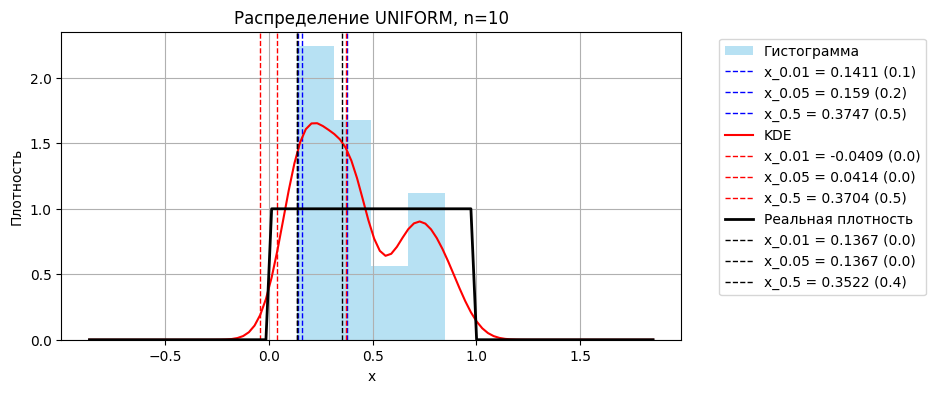

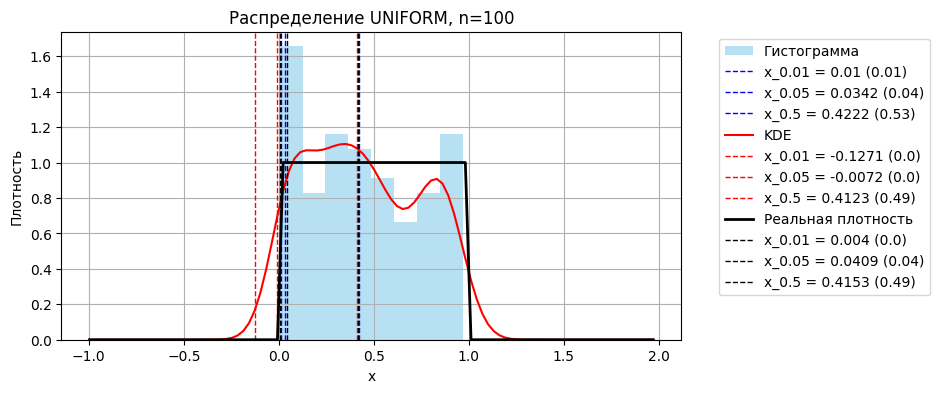

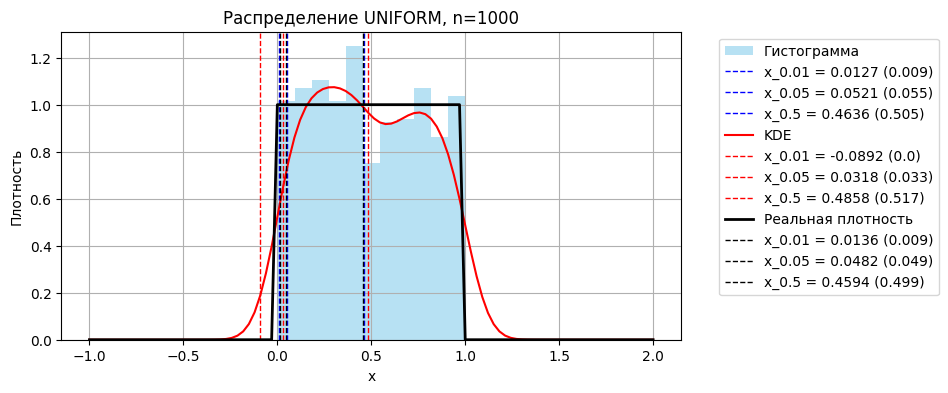

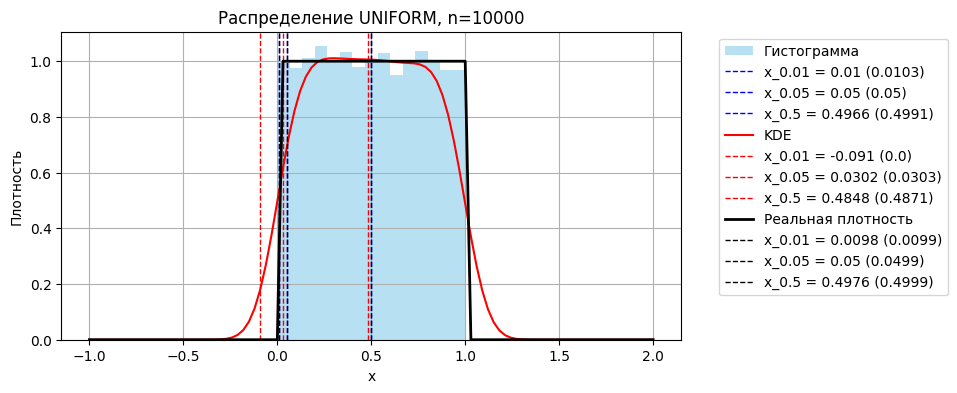

In [38]:
def analyze(dist_name, sample_size, qs):
    sample = DISTRIBUTIONS[dist_name](sample_size)
    xs = np.linspace(np.min(sample) - 1, np.max(sample) + 1, PRECISION)
    plt.figure(figsize=(8,4))

    hist, bins = make_hist(sample, histogram_nbins(sample_size))
    plt.hist(sample, bins=bins, density=True, color="skyblue", alpha=0.6, label="Гистограмма")
    hist_qs = hist_quantile(hist, bins, qs)
    for hist_qi, qi in zip(hist_qs, qs):
        plt.axvline(hist_qi, color="b", linestyle="--", 
                 label=f"x_{qi} = {round(hist_qi, 4)} ({np.mean(sample < hist_qi)})",
                 linewidth=1,)

    kde_pdf = make_kde(sample, xs, SIGMA)
    plt.plot(xs, kde_pdf, "r-", label="KDE")
    kde_qs = kde_quantile(kde_pdf, xs, qs)
    for kde_qi, qi in zip(kde_qs, qs):
        plt.axvline(kde_qi, color="r", linestyle="--",
            label=f"x_{qi} = {round(kde_qi, 4)} ({np.mean(sample < kde_qi)})",
            linewidth=1,)

    if dist_name == "NORMAL":
        true_pdf = scipy.stats.norm.pdf(xs)
    elif dist_name == "UNIFORM":
        true_pdf = scipy.stats.uniform.pdf(xs)
    plt.plot(xs, true_pdf, "k-", lw=2, label="Реальная плотность")
    ecdf_qs = sample_quantile(sample, qs)
    for ecdf_qi, qi in zip(ecdf_qs, qs):
        plt.axvline(ecdf_qi, color="k", linestyle="--",
            label=f"x_{qi} = {round(ecdf_qi, 4)} ({np.mean(sample < ecdf_qi)})",
            linewidth=1,)

    plt.title(f"Распределение {dist_name}, n={sample_size}")
    plt.xlabel("x")
    plt.ylabel("Плотность")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

print(f"{SIGMA=}")
for s in SAMPLE_SIZE:
    analyze("UNIFORM", s, QUANTILES)

In [23]:
def experiment(args):
    i, (dist_name, sample_size) = args

    sample = DISTRIBUTIONS[dist_name](sample_size)
    xs = np.linspace(np.min(sample) - 1, np.max(sample) + 1, PRECISION)

    hist, bins = make_hist(sample, histogram_nbins(sample_size))
    kde = make_kde(sample, xs, SIGMA)

    sample_xqs = sample_quantile(sample, QUANTILES)
    kde_xqs = kde_quantile(kde, X_SPACE, QUANTILES)
    hist_xqs = hist_quantile(hist, bins, QUANTILES)

    results = [
        (dist_name, sample_size, i, "emp", sample_xqs),
        (dist_name, sample_size, i, "hist", hist_xqs),
        (dist_name, sample_size, i, "kde", kde_xqs),
    ]
    return results

In [24]:
n_exp = 1 # NUM_EXPERIMENTS
rss = process_map(experiment, itertools.product(range(n_exp), EXPERIMENT_PARAMS))

data = [
    r
    for rs in rss
    for r in rs
]

8it [00:02,  2.99it/s]


In [31]:
df = pd.DataFrame(data, columns=("dist_name", "sample_size", "exp_num", "exp_type", "quantiles"))

In [33]:
df_norm = df[df["dist_name"] == "NORMAL"]

,dist_name,sample_size,exp_num,exp_type,quantiles
0,NORMAL,10,0,emp,"[-2.4481664785177832, -2.4481664785177832, -0...."
1,NORMAL,10,0,hist,"[-2.3525934729340867, -1.970301450599301, -0.2..."
2,NORMAL,10,0,kde,"[0.13131313131313133, 0.17171717171717174, 0.5..."
3,NORMAL,100,0,emp,"[-2.4481664785177832, -1.425014725732145, -0.0..."
4,NORMAL,100,0,hist,"[-2.220822618192302, -1.614572323991018, -0.04..."
5,NORMAL,100,0,kde,"[0.15151515151515152, 0.26262626262626265, 0.4..."
6,NORMAL,1000,0,emp,"[-2.3525841953689497, -1.6607404115221636, 0.0..."
7,NORMAL,1000,0,hist,"[-2.4302486293285694, -1.7563360866518667, -8...."
8,NORMAL,1000,0,kde,"[0.19191919191919193, 0.2828282828282829, 0.47..."
9,NORMAL,10000,0,emp,"[-2.3132119701383465, -1.6117279827250346, 0.0..."
